In [84]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm import compute_fixed_effects
from nilearn.glm.second_level import SecondLevelModel
import subprocess
from IPython.display import SVG
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
def compute_vifs(design_matrix):
    vif_data = pd.DataFrame()
    vif_data['Var'] = design_matrix.columns
    vif_data['VIF'] = [variance_inflation_factor(design_matrix.values, i) for i in range(design_matrix.shape[1])]
    return vif_data

In [86]:
subj_id = "172635"
test_fmriprep_path = "/scratch.global/mdemiden/hcp_bold_test"
schematic_path = "/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskevents"
events_path = "/home/feczk001/mdemiden/data/hcp_events"

In [85]:
os.listdir(test_fmriprep_path)

['sub-110007', 'sub-142424', 'sub-172635', 'sub-378857', 'sub-837964']

In [ ]:
s3_fmriprep_sublist = ["s3cmd", "ls", "s3://hcp-youth/derivatives/fmriprep_v24_0_1/ses-3T/", "--exclude", "*.html", "--exclude", "*sourcedata"]
sub_list = subprocess.run(s3_fmriprep_sublist, capture_output=True, text=True)
lines = sub_list.stdout.splitlines()
subjects = [line.split()[-1] for line in lines if line] 

In [ ]:
down_to_path = "/tmp/"
input_s3path = "s3://hcp-youth/derivatives/fmriprep_v24_0_1/ses-3T"
# Construct the S3 sync command
s3_download_fmriprepderiv = [
    "s3cmd", "sync", "--recursive",
    f"{input_s3path}/sub-{subj_id}", down_to_path,
    "--exclude", "*.h5",
    "--exclude", "*xfm.json",
    "--exclude", "*boldref*",
    "--exclude", "*.gii",
    "--exclude", "*91k*",
    "--exclude", "*_T2w.nii.gz",
    "--exclude", "*_T21w.nii.gz",
    "--exclude", "*dseg.nii.gz"
]
sync_result = subprocess.run(s3_download_fmriprepderiv, capture_output=True, text=True)

# Motor Task

Barch et al. (2013, pg 181). "Five predictors were included in the **Motor model** — right hand, left hand, right foot, left foot, and tongue. Each predictor covered the duration of 10 movement trials (12 s). The 3 s cue period prior to each motor block was modeled separately to account for visual activation related to the cue word presented on the screen at the beginning of each block. Linear contrasts were computed to estimate activation for each movement type versus baseline and versus all other movement types."

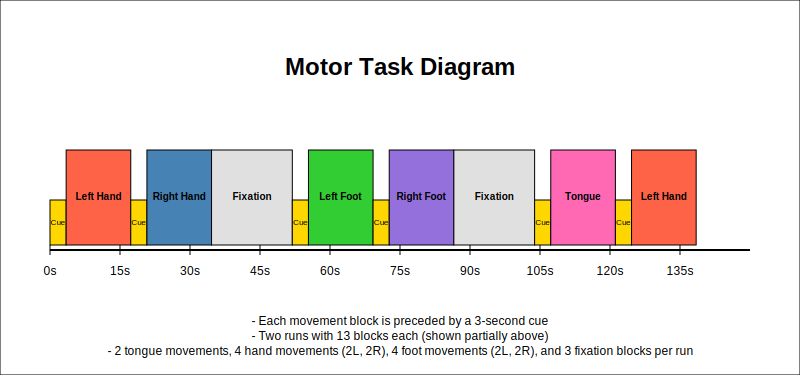

In [138]:
task = "motor"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [139]:
numvols = 284
boldtr = .720
run = 'run-1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')

### HCP Model

In [161]:
event_dfcpy = event_df.copy()
event_dfcpy.loc[event_dfcpy['trial_type'].str.contains('cue', na=False), 'trial_type'] = (
    event_dfcpy['trial_type'].str.split('_').str[0]
)
designevents_hcp = pd.DataFrame({'trial_type': event_dfcpy['trial_type'], 'onset': event_dfcpy['onset'], 'duration': event_dfcpy['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_hcp = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_hcp,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

<AxesSubplot:label='conditions', ylabel='scan number'>

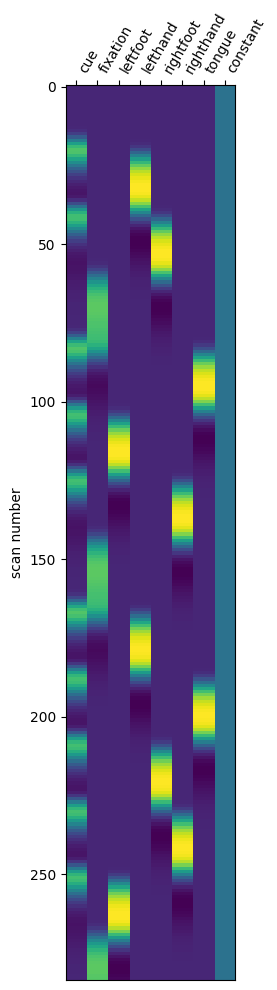

In [162]:
vif_hcp = compute_vifs(designmat_hcp)
vif_hcp["Source"] = "VIF_HCP"
plot_design_matrix(designmat_hcp)

### Alt Model

In [163]:
designevents_alt = pd.DataFrame({'trial_type': event_df['trial_type'], 'onset': event_df['onset'], 'duration': event_df['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_alt = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_alt,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

In [ ]:
vif_alt = compute_vifs(designmat_alt)
vif_alt["Source"] = "VIF_Alt"

<AxesSubplot:label='conditions', ylabel='scan number'>

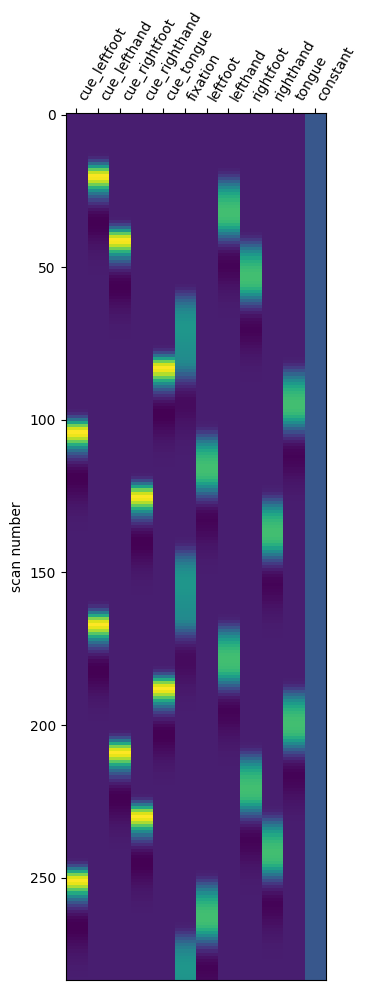

In [165]:
plot_design_matrix(design_matrix)

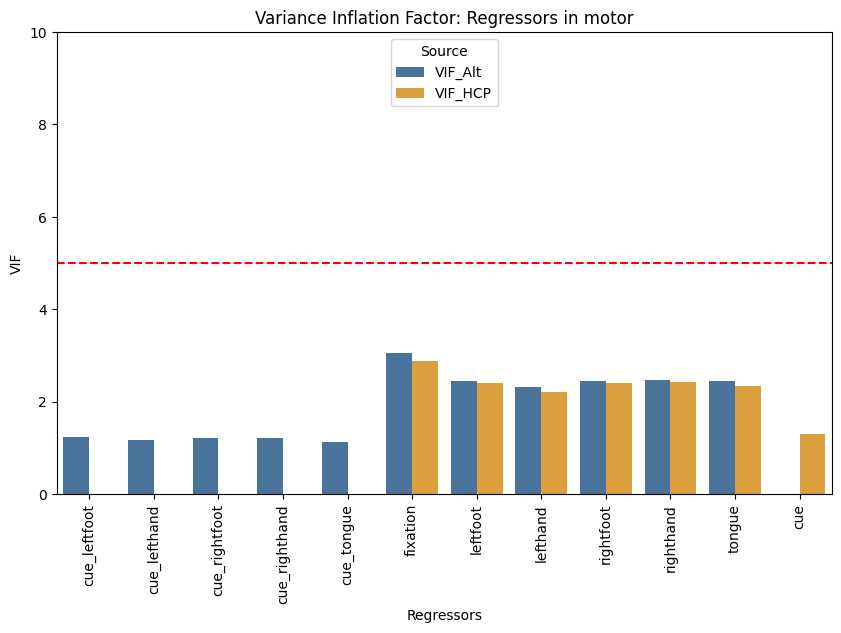

In [166]:
vif_combined = pd.concat([vif_alt, vif_hcp])
plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', hue='Source', data=vif_combined[vif_combined['Var'] != 'constant'], palette=['#3c73a8', '#f5a623'])

# Formatting
plt.ylim(0, 10)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {task}')
plt.xticks(rotation=90, fontsize=10)
plt.legend(title="Source")  # Legend to differentiate the datasets
plt.show()

# Gamble

Barch et al. (2013, pg 181). "Two predictors were included in the model for **Incentive Processing** — mostly reward and mostly loss blocks, each covering the duration of 8 trials (28 s). For this task, as with all other tasks, linear contrasts of the parameter estimates were computed to compare each condition to baseline and to each other."

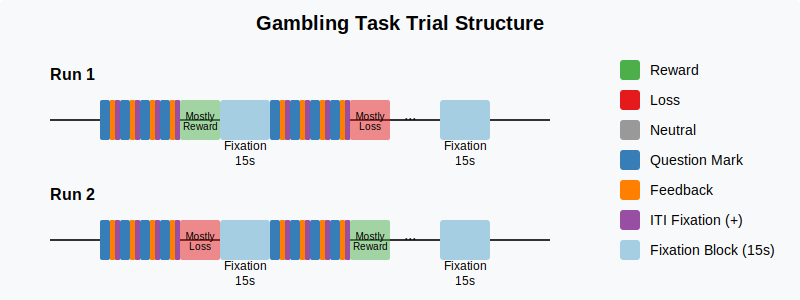

In [180]:
task = "gambling"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Events Design Matrix

In [181]:
numvols = 253
boldtr = .720
run = 'run-1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')

### HCP Model

In [182]:
include_trialtypes = ['full_gamble']
eventdf_cpy = event_df[event_df['trial_type'].isin(include_trialtypes)].copy() # exclude full block

# 
eventdf_cpy['mod_trialtype'] = eventdf_cpy['trial_type'] + '_' + eventdf_cpy['mostly_reward'].map({1: 'reward', 0: 'loss'})
# note, initial run at times contains a zeros for feedback / filler. These result as non/na values so these should be dropped.
# altering user of instance
missing_count = eventdf_cpy['onset'].isna().sum()

if missing_count > 0:
    print(f"Dropping {missing_count} rows with None/NaN in 'onsets' / 'durations' column.")
    eventdf_cpy = eventdf_cpy.dropna(subset=['onset'])
else:
    print("No None/NaN values found in 'onsets' column.")

No None/NaN values found in 'onsets' column.


In [183]:
designevents_hcp = pd.DataFrame({'trial_type': eventdf_cpy['mod_trialtype'], 'onset': eventdf_cpy['onset'], 'duration': eventdf_cpy['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_hcp = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_hcp,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

In [191]:
vif_hcp = compute_vifs(designmat_hcp)
vif_hcp["Source"] = "VIF_HCP"

<AxesSubplot:label='conditions', ylabel='scan number'>

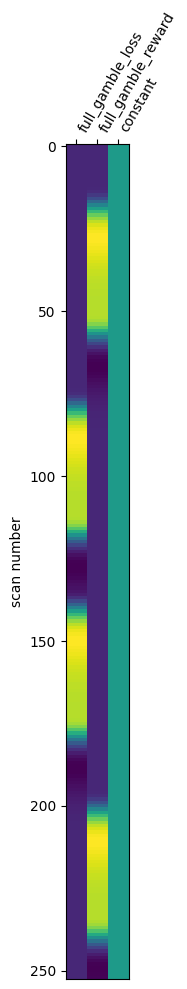

In [192]:
plot_design_matrix(designmat_hcp)

### Alt Model

In [198]:
include_trialtypes = ['quest_mark', 'filler', 'feedback']
eventdf_cpy = event_df[event_df['trial_type'].isin(include_trialtypes)].copy() # exclude full block

eventdf_cpy['mod_trialtype'] = eventdf_cpy['trial_type'] + '_' + eventdf_cpy['reward_type']
# note, initial run at times contains a zeros for feedback / filler. These result as non/na values so these should be dropped.
# altering user of instance
missing_count = eventdf_cpy['onset'].isna().sum()

if missing_count > 0:
    print(f"Dropping {missing_count} rows with None/NaN in 'onsets' / 'durations' column.")
    eventdf_cpy = eventdf_cpy.dropna(subset=['onset'])
else:
    print("No None/NaN values found in 'onsets' column.")

No None/NaN values found in 'onsets' column.


In [199]:
designevents_alt = pd.DataFrame({'trial_type': eventdf_cpy['mod_trialtype'], 'onset': eventdf_cpy['onset'], 'duration': eventdf_cpy['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_alt = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_alt,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

/panfs/jay/groups/2/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/.venv/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
filler_Punishment, filler_Reward.
  warnings.warn(


In [200]:
vif_alt = compute_vifs(designmat_alt)
vif_alt["Source"] = "VIF_Alt"

<AxesSubplot:label='conditions', ylabel='scan number'>

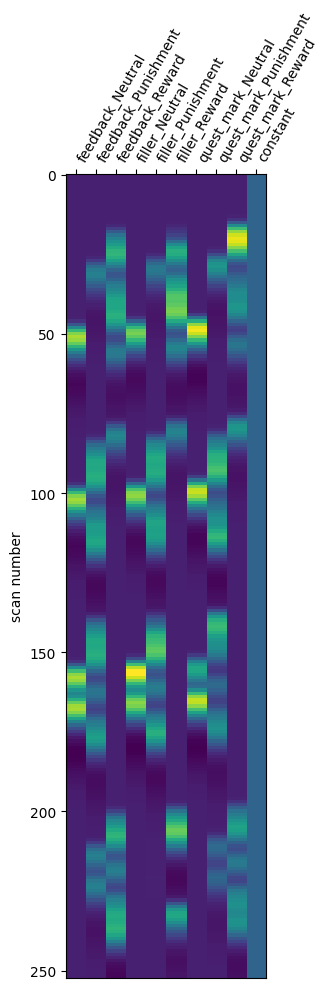

In [201]:
plot_design_matrix(designmat_alt)

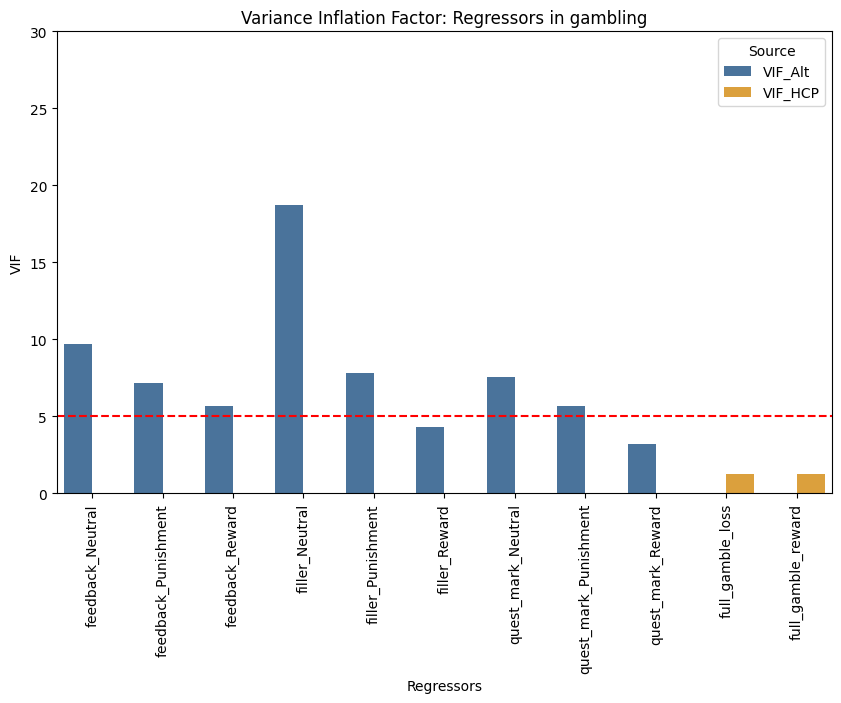

In [203]:
vif_combined = pd.concat([vif_alt, vif_hcp])
plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', hue='Source', data=vif_combined[vif_combined['Var'] != 'constant'], palette=['#3c73a8', '#f5a623'])

# Formatting
plt.ylim(0, 30)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {task}')
plt.xticks(rotation=90, fontsize=10)
plt.legend(title="Source")  # Legend to differentiate the datasets
plt.show()

# Social 

Barch et al. (2013, pg 181). "Two predictors were included in the Social Cognition model — Social and Random motion. Predictors were based on the category of the video clip rather than the rating of the individual. Each predictor covered the duration of a single video clip (20 s)."

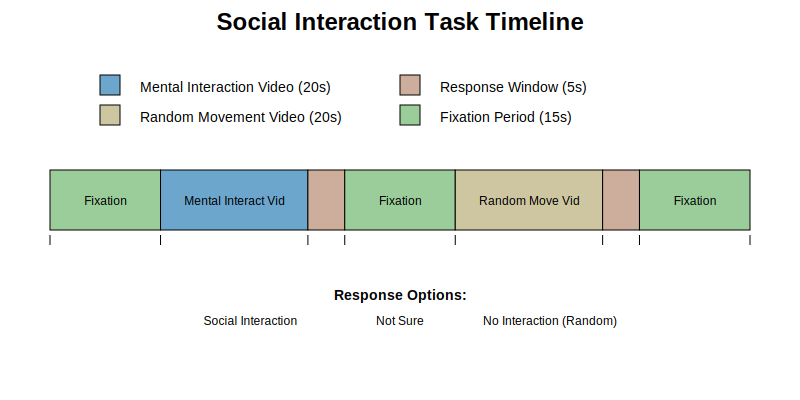

In [205]:
task = "social"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix 

In [206]:
numvols = 274
boldtr = .720
run = 'run-1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')



### HCP Model

In [209]:
include_trialtypes = ['movie']
eventdf_cpy = event_df[event_df['trial_type'].isin(include_trialtypes)].copy() # exclude full block

# 
eventdf_cpy['mod_trialtype'] = eventdf_cpy['trial_type'] + '_' + eventdf_cpy['social_type']

In [210]:
designevents_hcp = pd.DataFrame({'trial_type': eventdf_cpy['mod_trialtype'], 'onset': eventdf_cpy['onset'], 'duration': eventdf_cpy['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_hcp = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_hcp,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

In [211]:
vif_hcp = compute_vifs(designmat_hcp)
vif_hcp["Source"] = "VIF_HCP"

<AxesSubplot:label='conditions', ylabel='scan number'>

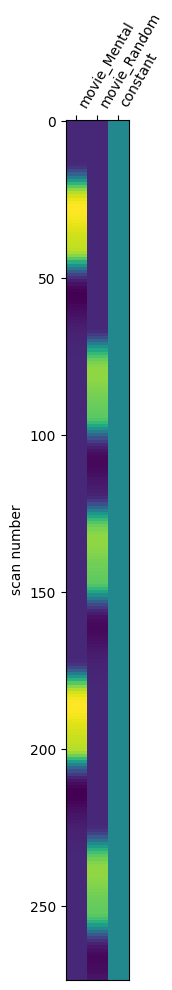

In [212]:
plot_design_matrix(designmat_hcp)

### Alt Model

In [213]:
include_trialtypes = ['movie', 'response']
eventdf_cpy = event_df[event_df['trial_type'].isin(include_trialtypes)].copy() # exclude full block
 
eventdf_cpy['mod_trialtype'] = eventdf_cpy['trial_type'] + '_' + eventdf_cpy['social_type']

In [214]:
designevents_alt = pd.DataFrame({'trial_type': eventdf_cpy['mod_trialtype'], 'onset': eventdf_cpy['onset'], 'duration': eventdf_cpy['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_alt = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_alt,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

<AxesSubplot:label='conditions', ylabel='scan number'>

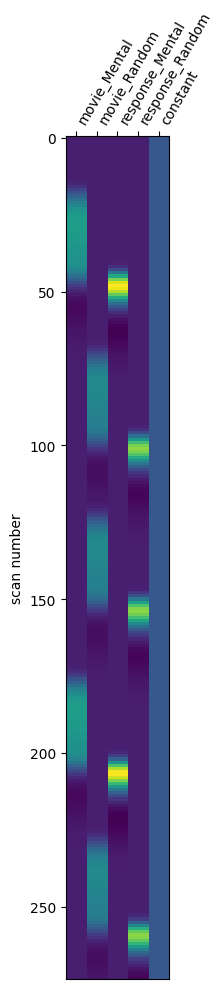

In [215]:
plot_design_matrix(designmat_alt)

In [216]:
vif_alt = compute_vifs(designmat_alt)
vif_alt["Source"] = "VIF_Alt"

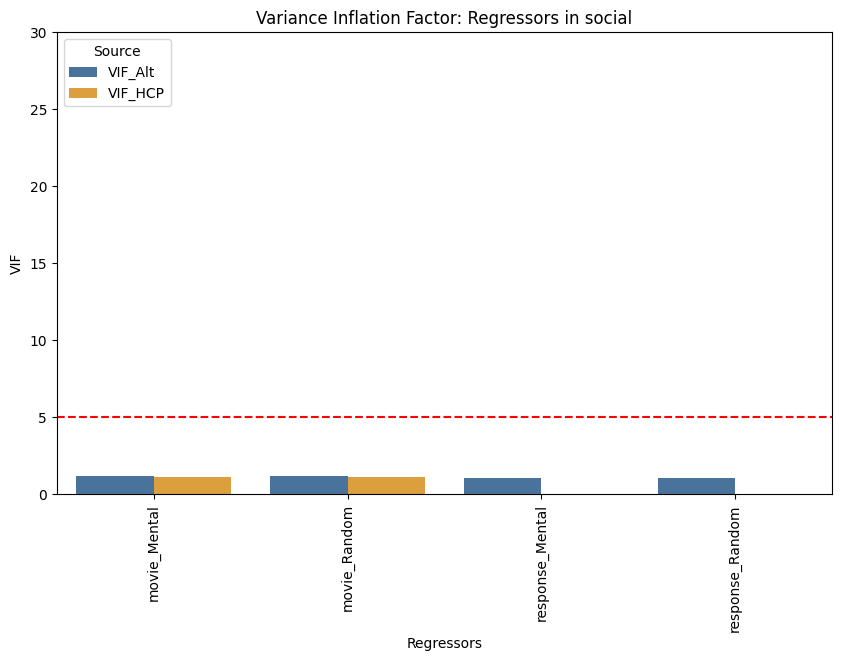

In [217]:
vif_combined = pd.concat([vif_alt, vif_hcp])
plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', hue='Source', data=vif_combined[vif_combined['Var'] != 'constant'], palette=['#3c73a8', '#f5a623'])

# Formatting
plt.ylim(0, 30)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {task}')
plt.xticks(rotation=90, fontsize=10)
plt.legend(title="Source")  # Legend to differentiate the datasets
plt.show()

# Language

Barch et al. (2013, pg 181). "Two predictors were included in the Language Processing model — Math and Story. The Story predictor covered the variable duration of a short story, question, and response period (~30 s). The Math predictor covered the duration of a set of math questions designed to roughly match the duration of the story blocks."

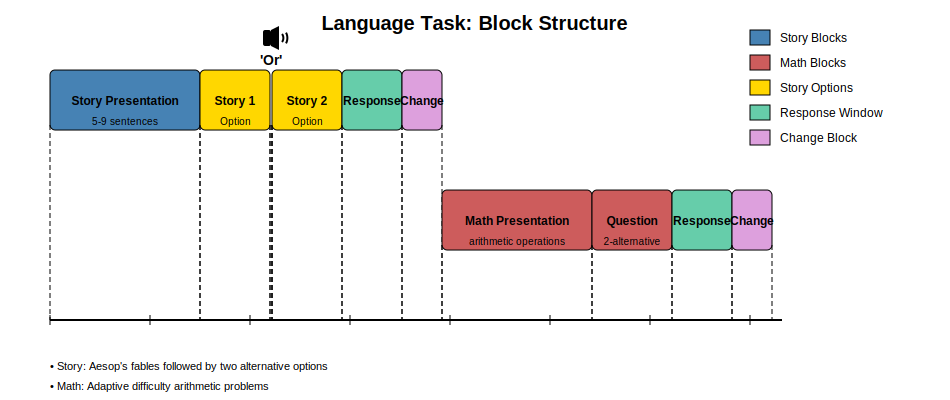

In [218]:
task = "language"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [219]:
numvols = 316
boldtr = .720
run = 'run-1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')

In [221]:
event_df

,Unnamed: 0,onset,duration,trial_type,block,response_time,accuracy,response,word_opt,overall_acc,filtered_rttime,math_lvl
0,0,0.245,18.669,present_story,Story_Block1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.245,19.192,story_to_question,Story_Block1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.245,25.914,full_story,Story_Block1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,19.437,1.163,question_story,Story_Block1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,20.797,0.677,story_opt1,Story_Block1,3862.0,0.0,2.0,taking,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
57,57,165.498,12.510,full_math,Math_Block6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,58,165.498,6.345,math_to_question,Math_Block6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,59,171.843,3.166,question_math,Math_Block6,NaN,NaN,NaN,NaN,NaN,NaN,11.0
60,60,175.042,2.966,math_answer,Math_Block6,3283.0,0.0,3.0,NaN,100.0,224716.0,11.0


### HCP Model

In [222]:
include_trialtypes = ['full_story','full_math']
eventdf_cpy = event_df[event_df['trial_type'].isin(include_trialtypes)].copy() # exclude full block

In [225]:
designevents_hcp = pd.DataFrame({'trial_type': eventdf_cpy['trial_type'], 'onset': eventdf_cpy['onset'], 'duration': eventdf_cpy['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_hcp = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_hcp,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

In [229]:
vif_hcp = compute_vifs(designmat_hcp)
vif_hcp["Source"] = "VIF_HCP"

<AxesSubplot:label='conditions', ylabel='scan number'>

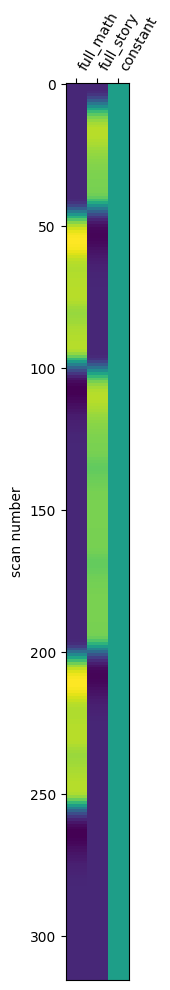

In [227]:
plot_design_matrix(designmat_hcp)

### Alt Model

In [237]:
include_trialtypes = ['present_story','question_story','story_answer',
                     'present_math','question_math','math_answer']
eventdf_cpy = event_df[event_df['trial_type'].isin(include_trialtypes)].copy() # exclude full block

In [238]:
designevents_alt = pd.DataFrame({'trial_type': eventdf_cpy['trial_type'], 'onset': eventdf_cpy['onset'], 'duration': eventdf_cpy['duration']})

frame_times = np.arange(numvols) * boldtr

designmat_alt = make_first_level_design_matrix(
        frame_times=frame_times,
        events=designevents_alt,
        hrf_model='spm',
        drift_model=None,
        #add_regs=conf_df.filter(regex="^(cosine|trans|rot)").fillna(0) # first volumes have nans, so need to make them zero to avoid error
        )

<AxesSubplot:label='conditions', ylabel='scan number'>

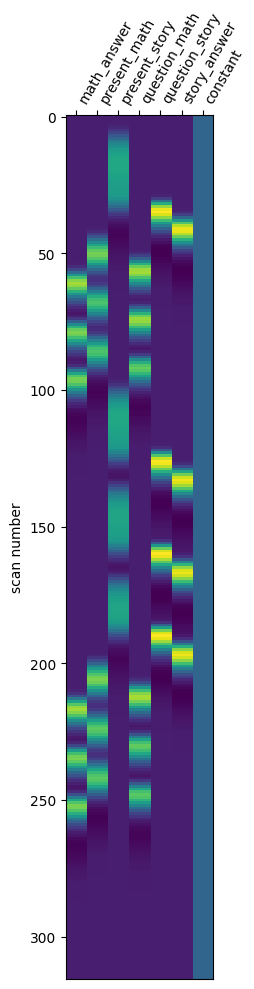

In [239]:
plot_design_matrix(designmat_alt)

In [240]:
vif_alt = compute_vifs(designmat_alt)
vif_alt["Source"] = "VIF_Alt"

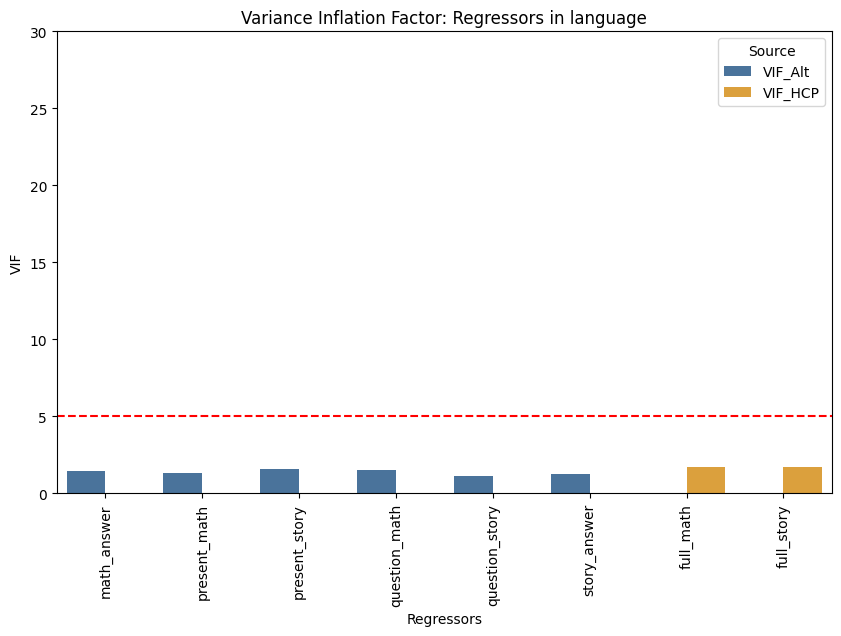

In [241]:
vif_combined = pd.concat([vif_alt, vif_hcp])
plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', hue='Source', data=vif_combined[vif_combined['Var'] != 'constant'], palette=['#3c73a8', '#f5a623'])

# Formatting
plt.ylim(0, 30)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {task}')
plt.xticks(rotation=90, fontsize=10)
plt.legend(title="Source")  # Legend to differentiate the datasets
plt.show()

# Relational

Barch et al. (2013, pg 181). "Two predictors were included in the Relational Processing model — Relational processing and a control Matching condition. Each predictor covered the duration of 18 s composed of four trials for the Relational condition and five trials for the Matching condition."

In [ ]:
task = "relational"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [ ]:
numvols = 176
boldtr = .720
run = 'run-1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')

# Emotion

Barch et al. (2013, pg 181-182). "Two predictors were included in the Emotion Processing model — Emotional Faces and a Shape control condition. Each predictor covered a 21 s duration composed of a cue and six trials."

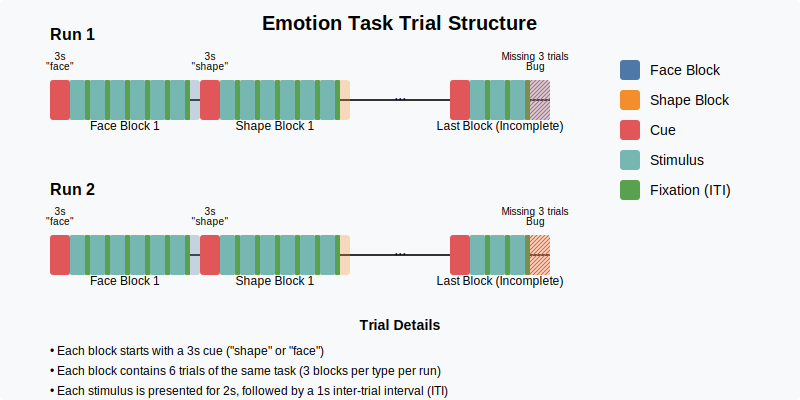

In [121]:
task = "emotion"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

# Working Memory

Barch et al. (2013, pg 181).  "For both analysis streams, eight predictors were included in the model for Working Memory/Category Specific Representations — one for each type of stimulus in each of the N-back conditions (i.e., 2-Back Body, 0-Back Body, 2-Back Face and  0-Back Face). Each predictor covered the period from the onset of the cue to the offset of the final trial (27.5 s). Linear contrasts for these predictors were computed to estimate effects of interest: 2-back (vs. fixation), 0-back, 2-back vs. 0-back, each stimulus type versus baseline (e.g., Body vs. fixation, collapsing across memory load), and each stimulus type versus all others."

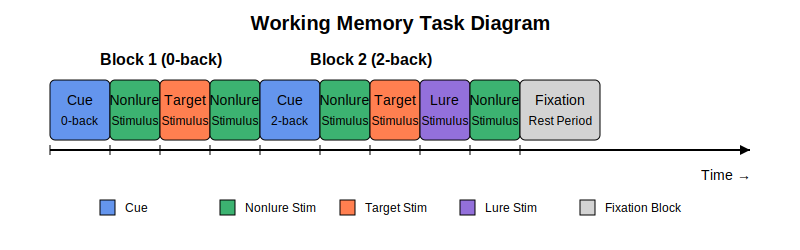

In [126]:
task = "wm" # WM for fmriprep output
task_img = f"{schematic_path}/info_{task}/workmemory_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [127]:
numvols = 405
boldtr = .720
run = 'run-1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')